# Anomaly Detection with Transformers

This tutorial illustrates how to use MONAI to perform image-wise anomaly detection with transformers based on the method proposed in Pinaya et al.[1].

Here, we will work with the [MedNIST dataset](https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset) available on MONAI, and similar to "Experiment 2 – image-wise anomaly detection on 2D synthetic data" from [1], we will train our generative models on `HeadCT` images.

Finally, we will compute the log-likelihood of images from the same class (in-distribution class) and images from other classes (out-of-distribution).

[1] - [Pinaya et al. "Unsupervised brain imaging 3D anomaly detection and segmentation with transformers"](https://doi.org/10.1016/j.media.2022.102475)

### Setup environment

In [1]:
!python -c "import seaborn" || pip install -q seaborn
%matplotlib inline

### Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from ignite.utils import convert_tensor
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.nn import CrossEntropyLoss, L1Loss
from tqdm import tqdm

from generative.inferers import VQVAETransformerInferer
from generative.networks.nets import VQVAE, DecoderOnlyTransformer
from generative.utils.enums import OrderingType
from generative.utils.ordering import Ordering

print_config()

/media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-03-10 23:52:11,507 - A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
MONAI version: 1.2.dev2304
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.

In [3]:
# for reproducibility purposes set a seed
set_determinism(42)

### Setup a data directory and download dataset

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not
specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpaurm48lm


### Download training data

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.01, 0.01), (-0.01, 0.01)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4, persistent_workers=True)

MedNIST.tar.gz: 59.0MB [00:04, 13.4MB/s]                                                                                       

2023-03-10 23:52:16,176 - INFO - Downloaded: /tmp/tmpaurm48lm/MedNIST.tar.gz


2023-03-10 23:52:16,270 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-03-10 23:52:16,271 - INFO - Writing into directory: /tmp/tmpaurm48lm.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 47164/47164 [00:13<00:00, 3379.57it/s]


### Visualise some examples from the dataset

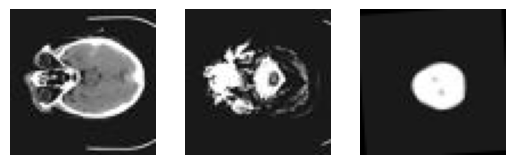

In [6]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

### Download Validation Data

In [7]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=4, persistent_workers=True)

2023-03-10 23:52:35,261 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-03-10 23:52:35,262 - INFO - File exists: /tmp/tmpaurm48lm/MedNIST.tar.gz, skipped downloading.
2023-03-10 23:52:35,262 - INFO - Non-empty folder exists in /tmp/tmpaurm48lm/MedNIST, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████| 5895/5895 [00:01<00:00, 3401.03it/s]


## Vector Quantized Variational Autoencoder

The first step is to train a Vector Quantized Variation Autoencoder (VQ-VAE). This network is responsible for creating a compressed version of the inputted data. Once its training is done, we can use the encoder to obtain smaller and discrete representations of the 2D images to generate the inputs required for our autoregressive transformer.

For its training, we will use the L1 loss, and we will update its codebook using a method based on Exponential Moving Average (EMA).

### Define network, optimizer and losses

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

vqvae_model = VQVAE(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_res_layers=2,
    downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
    upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
    num_channels=(256, 256),
    num_res_channels=(256, 256),
    num_embeddings=16,
    embedding_dim=64,
)
vqvae_model.to(device)

Using cuda


VQVAE(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (adn): ADN(
          (A): ReLU()
        )
      )
      (1): VQVAEResidualUnit(
        (conv1): Convolution(
          (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (conv2): Convolution(
          (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): VQVAEResidualUnit(
        (conv1): Convolution(
          (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (conv2): Convolution(
          (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

In [9]:
optimizer = torch.optim.Adam(params=vqvae_model.parameters(), lr=5e-4)
l1_loss = L1Loss()

### VQ-VAE Model training
We will train our VQ-VAE for 50 epochs.

In [10]:
n_epochs = 75
val_interval = 25
epoch_losses = []
val_epoch_losses = []

total_start = time.time()
for epoch in range(n_epochs):
    vqvae_model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        # model outputs reconstruction and the quantization error
        reconstruction, quantization_loss = vqvae_model(images=images)
        recons_loss = l1_loss(reconstruction.float(), images.float())
        loss = recons_loss + quantization_loss

        loss.backward()
        optimizer.step()

        epoch_loss += recons_loss.item()

        progress_bar.set_postfix(
            {"recons_loss": epoch_loss / (step + 1), "quantization_loss": quantization_loss.item() / (step + 1)}
        )
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        vqvae_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                reconstruction, quantization_loss = vqvae_model(images=images)
                recons_loss = l1_loss(reconstruction.float(), images.float())
                val_loss += recons_loss.item()

        val_loss /= val_step
        val_epoch_losses.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 72: 100%|████████████████| 32/32 [00:30<00:00,  1.05it/s, recons_loss=0.023, quantization_loss=0.000159]


Epoch 74: 100%|███████████████| 32/32 [00:30<00:00,  1.04it/s, recons_loss=0.0212, quantization_loss=0.000134]


train completed, total time: 2301.2195658683777.


### Plot reconstructions of final trained vqvae model

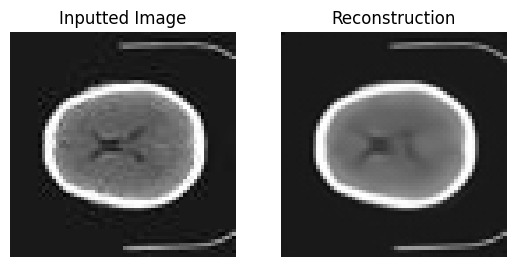

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(images[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")
ax[1].imshow(reconstruction[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

# Autoregressive Transformer

Now that our VQ-VAE model has been trained, we can use this model to encode the data into its discrete latent representations. Then, to be able to input it into the autoregressive Transformer, it is necessary to transform this 2D latent representation into a 1D sequence.

In order to train it in an autoregressive manner, we will use the CrossEntropy Loss as the Transformer will try to predict the next token value for each position of the sequence.

Here we will use the MONAI's `VQVAETransformerInferer` class to help with the forward pass and to get the predicted likelihood from the VQ-VAE + Transformer models.

### Datasets
We can use the same dataloader with augmentations as used for training the VQVAE model. However given the memory intensive nature of Transformers we will need to reduce the batch size.

In [12]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)

### 2D latent representation -> 1D sequence
We need to define an ordering of which we convert our 2D latent space into a 1D sequence. For this we will use a simple raster scan.

In [13]:
spatial_shape = next(iter(train_loader))["image"].shape[2:]

In [14]:
# Get spatial dimensions of data
# We divide the spatial shape by 4 as the vqvae downsamples the image by a factor of 4 along each dimension
spatial_shape = next(iter(train_loader))["image"].shape[2:]
spatial_shape = (int(spatial_shape[0] / 4), int(spatial_shape[1] / 4))

ordering = Ordering(ordering_type=OrderingType.RASTER_SCAN.value, spatial_dims=2, dimensions=(1,) + spatial_shape)

### Define network, inferer, optimizer and loss function

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_model = DecoderOnlyTransformer(
    num_tokens=16+1,
    max_seq_len=spatial_shape[0] * spatial_shape[1],
    attn_layers_dim=256,
    attn_layers_depth=20,
    attn_layers_heads=16,
)
transformer_model.to(device)

inferer = VQVAETransformerInferer()

In [16]:
optimizer = torch.optim.Adam(params=transformer_model.parameters(), lr=1e-4)
ce_loss = CrossEntropyLoss()

### Transformer Training
We will train the Transformer for 100 epochs.

In [17]:
n_epochs = 300
val_interval = 25
epoch_losses = []
val_epoch_losses = []
vqvae_model.eval()

total_start = time.time()
for epoch in range(n_epochs):
    transformer_model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:

        images = batch["image"].to(device)

        optimizer.zero_grad(set_to_none=True)


        logits, quantizations_target, _ = inferer(images, vqvae_model, transformer_model, ordering, return_latent=True)
        logits = logits.transpose(1, 2)
        
        loss = ce_loss(logits, quantizations_target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"ce_loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        transformer_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):

                images = batch["image"].to(device)

                logits, quantizations_target, _ = inferer(images, vqvae_model, transformer_model, ordering, return_latent=True)
                logits = logits.transpose(1, 2)
                
                loss = ce_loss(logits, quantizations_target)

                val_loss += loss.item()

        val_loss /= val_step
        val_epoch_losses.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 72: 100%|███████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s, ce_loss=0.000163]


Epoch 145: 100%|███████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s, ce_loss=4.95e-5]


Epoch 218: 100%|███████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s, ce_loss=1.68e-8]


Epoch 291: 100%|███████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s, ce_loss=1.82e-6]


Epoch 299: 100%|███████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s, ce_loss=4.09e-7]


train completed, total time: 29378.323362588882.


## Image-wise anomaly detection

To verify the performance of the VQ-VAE + Transformerperforming unsupervised anomaly detection, we will use the images from the test set of the MedNIST dataset. We will consider images from the `HeadCT` class as in-distribution images.

In [48]:
test_data = MedNISTDataset(root_dir=root_dir, section="test", download=True, seed=0)

in_distribution_datalist = [{"image": item["image"]} for item in test_data.data if item["class_name"] == "HeadCT"]
in_distribution_ds = Dataset(data=in_distribution_datalist, transform=val_transforms)
in_distribution_loader = DataLoader(
    in_distribution_ds, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True
)

in_likelihoods = []

progress_bar = tqdm(enumerate(in_distribution_loader), total=len(in_distribution_loader), ncols=110)
progress_bar.set_description(f"In-distribution data")
for step, batch in progress_bar:
    images = batch["image"].to(device)

    log_likelihood = inferer.get_likelihood(
        inputs=images, vqvae_model=vqvae_model, transformer_model=transformer_model, ordering=ordering
    )
    in_likelihoods.append(log_likelihood.sum(dim=(1, 2)).cpu().numpy())

in_likelihoods = np.concatenate(in_likelihoods)

2023-03-11 08:55:12,377 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-03-11 08:55:12,377 - INFO - File exists: /tmp/tmpaurm48lm/MedNIST.tar.gz, skipped downloading.
2023-03-11 08:55:12,378 - INFO - Non-empty folder exists in /tmp/tmpaurm48lm/MedNIST, skipped extracting.


In-distribution data: 100%|███████████████████████████████████████████████████| 17/17 [00:09<00:00,  1.75it/s]


We will use the "ChestCT" class of the dataset for the out-of-distribution examples.

In [65]:
ood_datalist = [{"image": item["image"]} for item in test_data.data if item["class_name"] == "ChestCT"]
ood_ds = Dataset(data=ood_datalist, transform=val_transforms)
ood_loader = DataLoader(ood_ds, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

ood_likelihoods = []

progress_bar = tqdm(enumerate(ood_loader), total=len(ood_loader), ncols=110)
progress_bar.set_description(f"out-of-distribution data")
for step, batch in progress_bar:
    images = batch["image"].to(device)

    log_likelihood = inferer.get_likelihood(
        inputs=images, vqvae_model=vqvae_model, transformer_model=transformer_model, ordering=ordering
    )
    ood_likelihoods.append(log_likelihood.sum(dim=(1, 2)).cpu().numpy())

ood_likelihoods = np.concatenate(ood_likelihoods)

out-of-distribution data: 100%|███████████████████████████████████████████████| 16/16 [00:09<00:00,  1.71it/s]


## Log-likehood plot

Here, we plot the log-likelihood of the images. In this case, the lower the log-likelihood, the more unlikely the image belongs to the training set.

Text(0.5, 0, 'Log-likelihood')

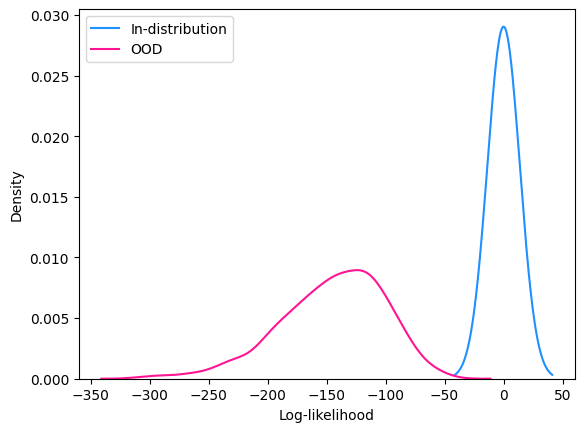

In [66]:
sns.kdeplot(in_likelihoods, color="dodgerblue", bw_adjust=1000000, label="In-distribution")
sns.kdeplot(ood_likelihoods, color="deeppink", bw_adjust=1,label="OOD")
plt.legend()
plt.xlabel("Log-likelihood")